<a href="https://colab.research.google.com/github/darkmatter2222/legendary-computing-machine/blob/main/FeedYourHead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Remember what the dormouse said: Feed your head  

Author: Ryan Susman, Director of AI/ML and Software Development at Fiserv   


---


## The purpose of this notebook:


*   To Inspire
*   Explore Machine Learning (ML)


---


## Subjects:


1.   General CSV Consumption
2.   DataFrame Exploration
3.   Charting
4.   Data Preperation for ML Training
5.   ML Training
6.   ML Predictions


---


How to use this Notebook:  
*    Execute each cell of this notebook from top to bottom one at a time. Pro tip Shift + Enter executed a cell and moves focus to the next cell.





# Lets begin by bringing in some data from a public repository
Data courtsy of Kaggle https://www.kaggle.com/kartik2112/fraud-detection?select=fraudTrain.csv and rehosted on Ryan Susman's Google Drive so you dont need to get a Kaggle account.  
Note, this data may not exist in my google drive forever... so you know...

In [2]:
import gdown
from tqdm import tqdm

data_source = [
  {'source':'https://drive.google.com/uc?id=1Y-mvdNzKKPGhpnB-NMxpVD9iVaZFGsCU',
  'destination':'/content/sample_data/fraudTest.csv',},
  {'source':'https://drive.google.com/uc?id=1Y-mvdNzKKPGhpnB-NMxpVD9iVaZFGsCU',
  'destination':'/content/sample_data/fraudTrain.csv',},
]

print('Downloading...')
for data in tqdm(data_source):
  gdown.download(data['source'], data['destination'], quiet=True)
print('Download Complete')

Downloading...


100%|██████████| 2/2 [00:10<00:00,  5.09s/it]

Download Complete


#  Let's explore the files


In [3]:
import pandas as pd
# open the CSVs into memory
train_df = pd.read_csv(r'/content/sample_data/fraudTrain.csv', index_col=0)
test_df = pd.read_csv(r'/content/sample_data/fraudTest.csv', index_col=0)

# add a column ('tick') to each and fill w/ '1', 
# you will understand later when we start grouping and counting rows
train_df['tick'] = 1
test_df['tick'] = 1

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
# lets look at train_df, this should contain all of our training data for the 
# upcomming Deep Neural Network we are going to train and predict from

# we can see it contains 1,296,675 records
# our 'tick' at the end to the right there as the last column
train_df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,tick
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,1
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,84735,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0,1
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,21790,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0,1
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0,1
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,57756,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0,1


In [5]:
# intristing distrubution of datatypes for each column.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

There are only 51 in this dataset


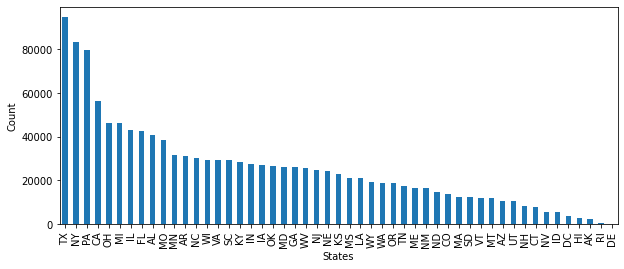

In [6]:
import matplotlib.pyplot as plt
# for the sake of exploration, what is the state distrubution? 
grouped_states = train_df.groupby(['state'])['tick'].sum().sort_values(ascending=False)
print(f'There are only {len(grouped_states)} in this dataset')
grouped_states.plot.bar(figsize=(10, 4), xlabel='States', ylabel='Count')

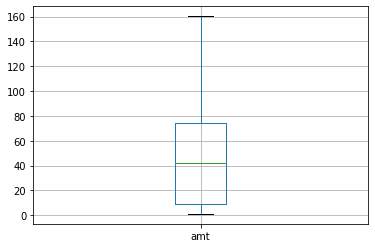

In [7]:
# what is the distrubution of $$$ (in 1 Standard Deviation) of the entire train set?
train_df[train_df['amt'] < train_df['amt'].std()].boxplot(column=['amt'], return_type='axes')

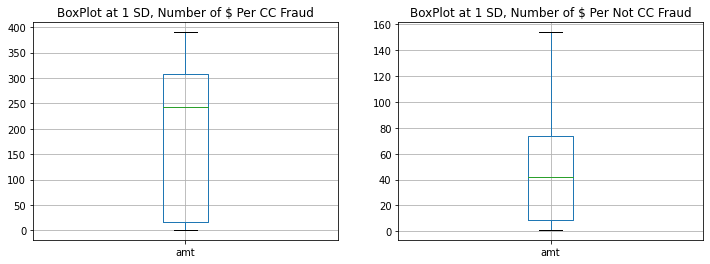

In [8]:
# what is the distrubution of $ (in 1 Standard Deviation(SD)) of the entire train 
# set for cases that are fraud?

# from a feature engineering perspective, it appers that $ is a factor if a 
# transaction is likely to be fraud or not.

figure, axis = plt.subplots(1, 2, figsize=(12, 4))

fraud_df = train_df[train_df['is_fraud'] == 1]
fraud_df[fraud_df['amt'] < fraud_df['amt'].std()].boxplot(
    column=['amt'], return_type='axes', ax=axis[0]).set_title(
        'BoxPlot at 1 SD, Number of $ Per CC Fraud')

not_fraud_df = train_df[train_df['is_fraud'] == 0]
not_fraud_df[not_fraud_df['amt'] < not_fraud_df['amt'].std()].boxplot(
    column=['amt'], return_type='axes', ax=axis[1]).set_title(
        'BoxPlot at 1 SD, Number of $ Per Not CC Fraud')

plt.show()

# Time to train!
Below we will be training a deep neural network

In [11]:
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer

vectorizerCount = CountVectorizer()
pd.DataFrame(vectorizerCount.fit_transform(train_df['city']))


,0
0,"(0, 584)\t1\n (0, 282)\t1"
1,"(0, 648)\t1"
2,"(0, 524)\t1\n (0, 161)\t1"
3,"(0, 93)\t1"
4,"(0, 240)\t1\n (0, 387)\t1"
...,...
1296670,"(0, 364)\t1"
1296671,"(0, 850)\t1"
1296672,"(0, 385)\t1\n (0, 741)\t1\n (0, 598)\t1\n ..."
1296673,"(0, 527)\t1"
